# Content extraction

1. Read the cont_image
2. Resize cont_image
3. Preprocess : RGB ->BGR and normalize
4. Create VGG_avg
5. Generate P(l) = activations for the cont_image at layer l
6. Generate F(l) = activations for white noise image at layer l
7. content_loss = MSE(P(l), F(l))

# Style extraction

1. Read the style_image
2. Resize style_image
3. Preprocess : RGB ->BGR and normalize
4. Create VGG_avg
5. Generate Gram_matrix for original image, A(L) =  Inner product of F x Ft for the layers L, 
where F is the vectorized feature map. (There is some weight to the loss for each layer?)
6. Generate Gram_matrix for white noise image, G(L) similarly above 
7. style_loss = MSE(A(L), G(L))

# Style transfer

1. loss(p,a,x) = a x content_loss(p,x) + b x style_loss(a,x), where p=content, a=artwork, x = generated image
2. Run SGD on fmin_l_bfgs_b(loss, x0=x, args=(p,a))

In [11]:
%matplotlib inline
import importlib
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

In [12]:
import sys
sys.path.append('../PreTrainedModels')
from vgg16_avg import VGG16_Avg

In [13]:
import sys
sys.path.append('../utilities')
import utils2; importlib.reload(utils2)
from utils2 import *

In [14]:
limit_mem()

In [15]:
dpath = '/home/sravya/data/style_transfer/'

# Read images and resize

In [2]:
content_img_raw=Image.open(dpath + 'yashoda.jpg'); content_img_raw

NameError: name 'Image' is not defined

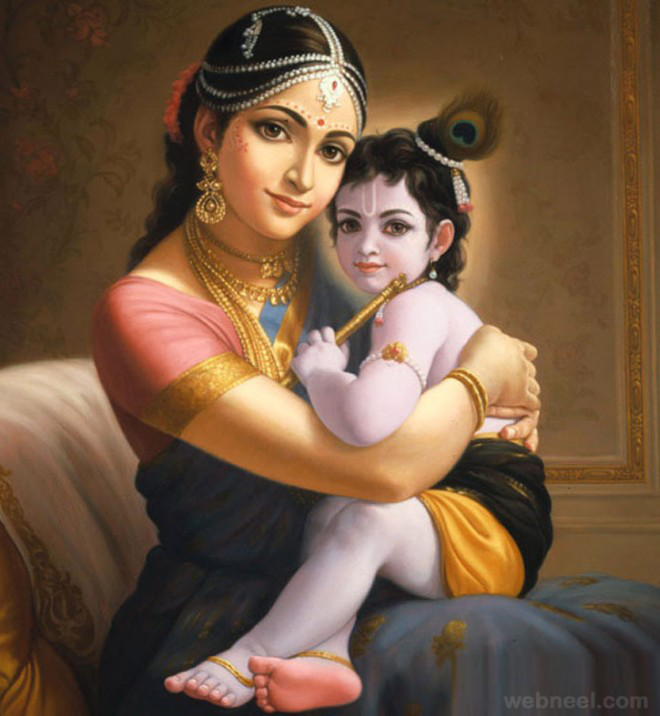

In [47]:
style_img_raw = Image.open(dpath + 'yashoda_art.jpg');style_img_raw

In [48]:
content_img_raw.size, style_img_raw.size

((596, 960), (660, 716))

In [1]:
content_img = content_img_raw.crop([50,0,600+50,960]);content_img

NameError: name 'content_img_raw' is not defined

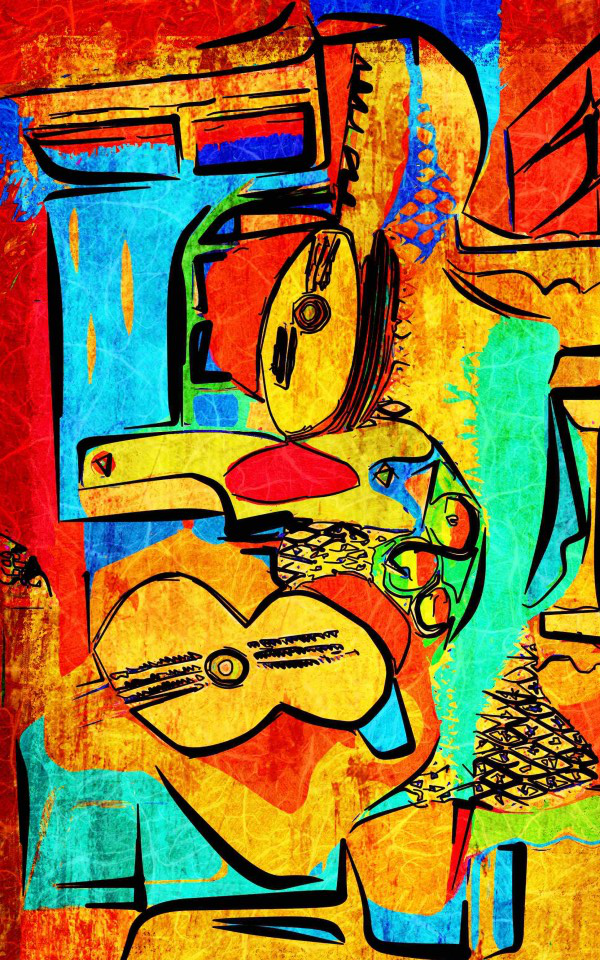

In [20]:
style_img = style_img_raw.rotate(90, expand=1).crop([0,0,600,960]);style_img

In [21]:
content_img.size,style_img.size

((600, 960), (600, 960))

# Preprocess for VGG

In [22]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [23]:
content_img_arr = preproc(np.expand_dims(np.array(content_img), 0))
style_img_arr = preproc(np.expand_dims(np.array(style_img), 0))

# Create VGG_avg

In [24]:
shp = style_img_arr.shape
#shp = style_img_arr.shape
model = VGG16_Avg(include_top=False, input_shape=shp[1:])

In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 960, 600, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 960, 600, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 960, 600, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (AveragePooling2D)   (None, 480, 300, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

# Create loss and gradients

In [26]:
outputs = {l.name: l.output for l in model.layers}

In [27]:
#Create content and style models
content_layer = outputs['block4_conv2']
content_model = Model(model.input, content_layer)
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
style_model = Model(model.input, style_layers)

In [28]:
#Create content model and generate y_true tensor
content_targ = K.variable(content_model.predict(content_img_arr))

In [29]:
#Create style model and generate y_true tensor
style_targs = [K.variable(o) for o in style_model.predict(style_img_arr)]

In [30]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [31]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [32]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [43]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, style_targs))
loss += metrics.mse(content_layer, content_targ)/2
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [34]:
evaluator = Evaluator(transfer_fn, shp)

# Create white noise image and fit using the evaluator

In [35]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)

In [39]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [36]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{dpath}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [37]:
x.shape

(1, 960, 600, 3)

In [44]:
x = solve_image(evaluator, 10, x)

Current loss value: 2802.99267578
Current loss value: 2696.05932617
Current loss value: 2617.60327148
Current loss value: 2544.81933594
Current loss value: 2480.02392578
Current loss value: 2439.47363281
Current loss value: 2390.94824219
Current loss value: 2363.16186523
Current loss value: 2317.61889648
Current loss value: 2276.40722656


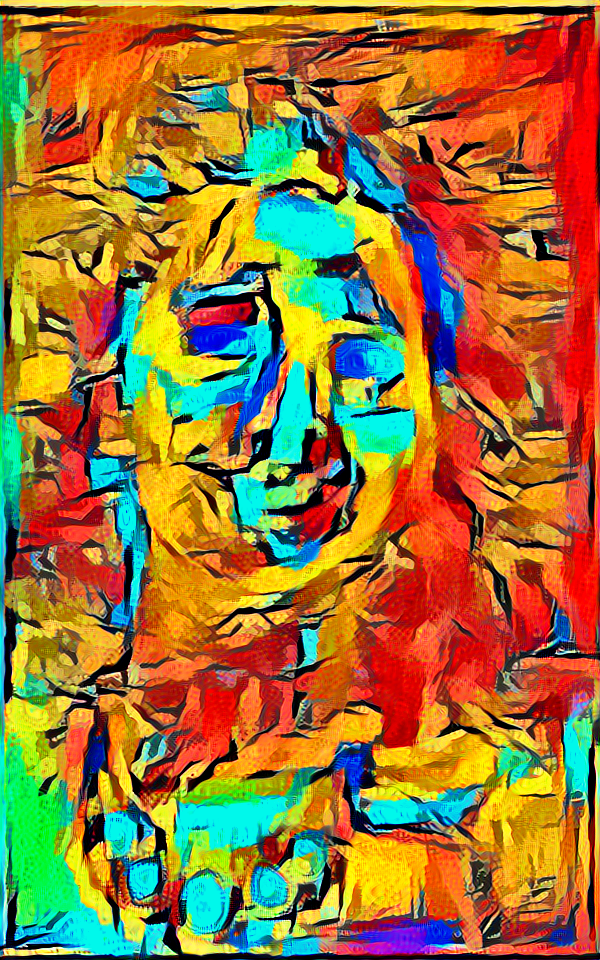

In [45]:
Image.open(dpath + 'results/res_at_iteration_2.png')

# Try without evaluator

In [ ]:
#Loss function
def loss_func(params,*args):
    content_targ = args[0]
    style_targs = args[1]
    x = params
    loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, style_targs))
    loss += metrics.mse(content_layer, content_targ)/3.
    return loss

In [ ]:
fmin_l_bfgs_b(loss_func, x0=x, args=(content_targ, style_targs), approx_grad=1)